In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip ./drive/MyDrive/traindata.zip > /dev/null

In [ ]:
!mkdir train test
!mkdir train/panvel train/amravati test/sri\ city
!cp -r ./data/amravati/images_masked ./train/amravati/
!cp -r ./data/amravati/masks ./train/amravati/
!cp -r ./data/panvel/images_masked ./train/panvel/
!cp -r ./data/panvel/masks ./train/panvel/
!cp -r ./data/sri\ city/images_masked ./test/sri\ city/
!cp -r ./data/sri\ city/masks ./test/sri\ city/

In [ ]:
!pip install geopandas > /dev/null
!pip install rioxarray > /dev/null
!pip install earthpy > /dev/null

In [ ]:
!pip install awscli > /dev/null

In [ ]:
!aws s3 ls s3://spacenet-dataset/spacenet/SN7_buildings/tarballs/ --no-sign-request

2020-08-24 16:54:40 1249078523 SN7_buildings_test_public.tar.gz
2020-08-24 16:44:58 9161814623 SN7_buildings_train.tar.gz
2020-08-24 16:45:47  495555469 SN7_buildings_train_csvs.tar.gz
2020-08-27 15:54:48  142357581 SN7_buildings_train_sample.tar.gz


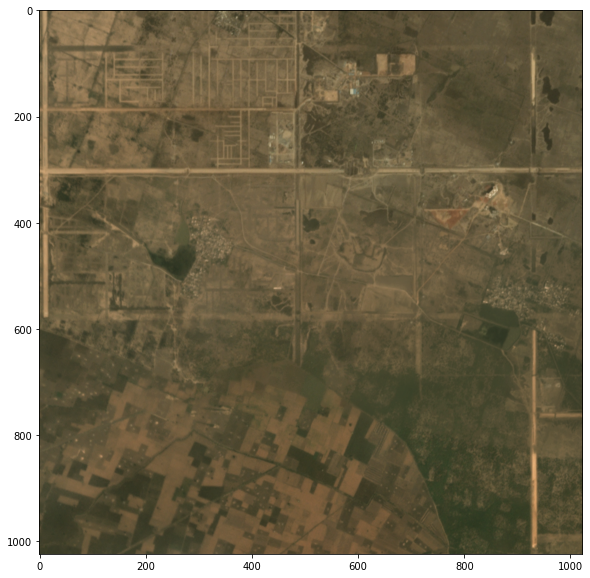

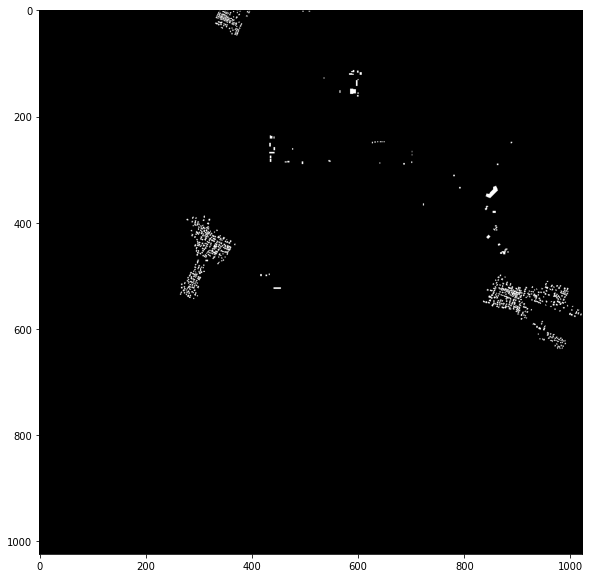

In [ ]:
from skimage import io
import matplotlib.pyplot as plt

image_path='./train/amravati/images_masked/global_monthly_2018_01_mosaic_L15-1481E-1119N_5927_3715_13.tif'
mask_path='./train/amravati/masks/global_monthly_2018_01_mosaic_L15-1481E-1119N_5927_3715_13.tif'
image = io.imread(image_path)
f, axarr = plt.subplots(figsize=(10, 10))
plt.imshow(image, cmap='gray')

fp_mask = io.imread(mask_path)
f, ax = plt.subplots(figsize=(10, 10))
plt.imshow(fp_mask, cmap='gray')

## **CODE FOR CREATING MASK**

In [ ]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from rasterio import features
import pyproj
import rasterio
import skimage



def _check_rasterio_im_load(im):
    """Check if `im` is already loaded in; if not, load it in."""
    if isinstance(im, str):
        return rasterio.open(im)
    elif isinstance(im, rasterio.DatasetReader):
        return im
    else:
        raise ValueError(
            "{} is not an accepted image format for rasterio.".format(im))
def _check_df_load(df):
    """Check if `df` is already loaded in, if not, load from file."""
    if isinstance(df, str):
        if df.lower().endswith('json'):
            return _check_gdf_load(df)
        else:
            return pd.read_csv(df)
    elif isinstance(df, pd.DataFrame):
        return df
    else:
        raise ValueError(f"{df} is not an accepted DataFrame format.")

def create_mask(path):
  images=os.listdir(os.path.join(path,'images/'))
  
  for image in images:
    if(image=='.ipynb_checkpoints'):
      continue
    label_match_pix=image.replace('.tif','_Buildings.geojson')
    out=image

    image_path=os.path.join(path,'images_masked',image)
    json_path=os.path.join(path,'labels_match_pix',label_match_pix)
    out_path=os.path.join(path,'masks',out)

    gdf = gpd.read_file(json_path)

    #gdf = _check_df_load(json_path)


    reference_im = _check_rasterio_im_load(image_path)
    shape = reference_im.shape 

    
    '''fp_mask=np.zeros(shape=shape, dtype='uint8')
    if len(gdf) != 0:
      fp_mask = features.rasterize(shapes=gdf.geometry.values,out_shape=shape)'''
    
    fp_mask = features.rasterize(shapes=gdf.geometry.values,out_shape=shape)

    meta = reference_im.meta.copy()
    meta.update(count=1)
    meta.update(dtype='uint8')
    meta.update(nodata=0)
    with rasterio.open(out_path, 'w',**meta) as dst:
      dst.write(fp_mask, indexes=1)




In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.utils import plot_model
from keras import backend as K

In [ ]:
def unet_model(n_classes=5, im_sz=160, n_channels=8, n_filters_start=32, growth_factor=2, upconv=True,
               class_weights=[0.2, 0.3, 0.1, 0.1, 0.3]):
    droprate=0.25
    n_filters = n_filters_start
    inputs = Input((im_sz, im_sz, n_channels))
    #inputs = BatchNormalization()(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    #pool1 = Dropout(droprate)(pool1)

    n_filters *= growth_factor
    pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(droprate)(pool2)

    n_filters *= growth_factor
    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(droprate)(pool3)

    n_filters *= growth_factor
    pool3 = BatchNormalization()(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4_0 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_0)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    pool4_1 = Dropout(droprate)(pool4_1)

    n_filters *= growth_factor
    pool4_1 = BatchNormalization()(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_1)
    conv4_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv4_1)
    pool4_2 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    pool4_2 = Dropout(droprate)(pool4_2)

    n_filters *= growth_factor
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(pool4_2)
    conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)

    n_filters //= growth_factor
    if upconv:
        up6_1 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv5), conv4_1])
    else:
        up6_1 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4_1])
    up6_1 = BatchNormalization()(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_1)
    conv6_1 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_1)
    conv6_1 = Dropout(droprate)(conv6_1)

    n_filters //= growth_factor
    if upconv:
        up6_2 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_1), conv4_0])
    else:
        up6_2 = concatenate([UpSampling2D(size=(2, 2))(conv6_1), conv4_0])
    up6_2 = BatchNormalization()(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up6_2)
    conv6_2 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv6_2)
    conv6_2 = Dropout(droprate)(conv6_2)

    n_filters //= growth_factor
    if upconv:
        up7 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv6_2), conv3])
    else:
        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6_2), conv3])
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(droprate)(conv7)

    n_filters //= growth_factor
    if upconv:
        up8 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    else:
        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(droprate)(conv8)

    n_filters //= growth_factor
    if upconv:
        up9 = concatenate([Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    else:
        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    def weighted_binary_crossentropy(y_true, y_pred):
        class_loglosses = K.mean(K.binary_crossentropy(y_true, y_pred), axis=[0, 1, 2])
        return K.sum(class_loglosses * K.constant(class_weights))

    model.compile(optimizer=Adam(), loss=weighted_binary_crossentropy)
    return model

In [ ]:
import random
import numpy as np

def get_rand_patch(img, mask, sz=160):
    """
    :param img: ndarray with shape (x_sz, y_sz, num_channels)
    :param mask: binary ndarray with shape (x_sz, y_sz, num_classes)
    :param sz: size of random patch
    :return: patch with shape (sz, sz, num_channels)
    """
    assert len(img.shape) == 3 and img.shape[0] > sz and img.shape[1] > sz and img.shape[0:2] == mask.shape[0:2]
    xc = random.randint(0, img.shape[0] - sz)
    yc = random.randint(0, img.shape[1] - sz)
    patch_img = img[xc:(xc + sz), yc:(yc + sz)]
    patch_mask = mask[xc:(xc + sz), yc:(yc + sz)]

    # Apply some random transformations
    random_transformation = np.random.randint(1,8)
    if random_transformation == 1:  # reverse first dimension
        patch_img = patch_img[::-1,:,:]
        patch_mask = patch_mask[::-1,:,:]
    elif random_transformation == 2:    # reverse second dimension
        patch_img = patch_img[:,::-1,:]
        patch_mask = patch_mask[:,::-1,:]
    elif random_transformation == 3:    # transpose(interchange) first and second dimensions
        patch_img = patch_img.transpose([1,0,2])
        patch_mask = patch_mask.transpose([1,0,2])
    elif random_transformation == 4:
        patch_img = np.rot90(patch_img, 1)
        patch_mask = np.rot90(patch_mask, 1)
    elif random_transformation == 5:
        patch_img = np.rot90(patch_img, 2)
        patch_mask = np.rot90(patch_mask, 2)
    elif random_transformation == 6:
        patch_img = np.rot90(patch_img, 3)
        patch_mask = np.rot90(patch_mask, 3)
    else:
        pass

    return patch_img, patch_mask


def get_patches(x_dict, y_dict, n_patches, sz=160):
    x = list()
    y = list()
    total_patches = 0
    while total_patches < n_patches:
        img_id = random.sample(x_dict.keys(), 1)[0]
        img = x_dict[img_id]
        mask = y_dict[img_id]
        img_patch, mask_patch = get_rand_patch(img, mask, sz)
        x.append(img_patch)
        y.append(mask_patch)
        total_patches += 1
    print('Generated {} patches'.format(total_patches))
    return np.array(x), np.array(y)

In [ ]:
import os.path
import numpy as np
import tifffile as tiff
from keras.callbacks import CSVLogger
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
def normalize(img):
    min = img.min()
    max = img.max()
    x = 2.0 * (img - min) / (max - min) - 1.0
    return x

In [ ]:
N_BANDS = 3
N_CLASSES = 1  # buildings, roads, trees, crops and water
CLASS_WEIGHTS = [0.2]#, 0.3]#, 0.1, 0.1, 0.3]
N_EPOCHS = 150
UPCONV = True
PATCH_SZ = 160   # should divide by 16
BATCH_SIZE = 150
TRAIN_SZ = 4000  # train size
VAL_SZ = 1000    # validation size

In [ ]:
def get_model():
    return unet_model(N_CLASSES, PATCH_SZ, n_channels=N_BANDS, upconv=UPCONV, class_weights=CLASS_WEIGHTS)

In [ ]:
weights_path = 'weights'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)
weights_path += '/unet_weights.hdf5'

This cell is to import weight from google drive. Do not run this cell if no weight is stored in your drive

In [ ]:
!cp -r /content/drive/MyDrive/unet_weights.hdf5 /content/weights/

In [ ]:
trainIds = {}
trainIds['panvel'] = os.listdir('./train/panvel/images_masked')
trainIds['amravati']=os.listdir('./train/amravati/images_masked')

In [ ]:

X_DICT_TRAIN = dict()
Y_DICT_TRAIN = dict()
X_DICT_VALIDATION = dict()
Y_DICT_VALIDATION = dict()

print('Reading images')
for city in trainIds.keys():
  for img_id in trainIds[city]:
      if(img_id=='.ipynb_checkpoints'):
        continue
      
      img_m = normalize(tiff.imread('./train/{}/images_masked/{}'.format(city,img_id)))
      shape=img_m.shape[:2]+(1,)
      print(shape)
      mask = tiff.imread('./train/{}/masks/{}'.format(city,img_id)).reshape(shape)/1.0 
      
      train_xsz = int(3/4 * img_m.shape[0])  # use 75% of image as train and 25% for validation
      X_DICT_TRAIN[img_id] = img_m[:train_xsz, :, :3]
      Y_DICT_TRAIN[img_id] = mask[:train_xsz, :, :]
      X_DICT_VALIDATION[img_id] = img_m[train_xsz:, :, :3]
      Y_DICT_VALIDATION[img_id] = mask[train_xsz:, :, :]
      print(img_id + ' read')
print('Images were read')

def train_net():
    print("start train net")
    x_train, y_train = get_patches(X_DICT_TRAIN, Y_DICT_TRAIN, n_patches=TRAIN_SZ, sz=PATCH_SZ)
    x_val, y_val = get_patches(X_DICT_VALIDATION, Y_DICT_VALIDATION, n_patches=VAL_SZ, sz=PATCH_SZ)
    print(x_val.shape)
    print(y_val.shape)
    model = get_model()
    if os.path.isfile(weights_path):
        model.load_weights(weights_path)
    #model_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', save_weights_only=True, save_best_only=True)
    #early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    #reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5, min_lr=0.00001)
    model_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True)
    csv_logger = CSVLogger('log_unet.csv', append=True, separator=';')
    tensorboard = TensorBoard(log_dir='./tensorboard_unet/', write_graph=True, write_images=True)
    model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=N_EPOCHS,
              verbose=2, shuffle=True,
              callbacks=[model_checkpoint, csv_logger, tensorboard],
              validation_data=(x_val, y_val))
    return model

train_net()

This cell is to copy weight to drive. Run this cell if you want to store the weight.

In [ ]:
!cp -r ./weights/unet_weights.hdf5 ./drive/MyDrive/

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from PIL import Image
import cv2



def predict(x, model, patch_sz=160, n_classes=5):
    img_height = x.shape[0]
    img_width = x.shape[1]
    n_channels = x.shape[2]
    # make extended img so that it contains integer number of patches
    npatches_vertical = math.ceil(img_height / patch_sz)
    npatches_horizontal = math.ceil(img_width / patch_sz)
    extended_height = patch_sz * npatches_vertical
    extended_width = patch_sz * npatches_horizontal
    ext_x = np.zeros(shape=(extended_height, extended_width, n_channels), dtype=np.float32)
    # fill extended image with mirrors:
    ext_x[:img_height, :img_width, :] = x
    for i in range(img_height, extended_height):
        ext_x[i, :, :] = ext_x[2 * img_height - i - 1, :, :]
    for j in range(img_width, extended_width):
        ext_x[:, j, :] = ext_x[:, 2 * img_width - j - 1, :]

    # now we assemble all patches in one array
    patches_list = []
    for i in range(0, npatches_vertical):
        for j in range(0, npatches_horizontal):
            x0, x1 = i * patch_sz, (i + 1) * patch_sz
            y0, y1 = j * patch_sz, (j + 1) * patch_sz
            patches_list.append(ext_x[x0:x1, y0:y1, :])
    # model.predict() needs numpy array rather than a list
    patches_array = np.asarray(patches_list)
    # predictions:
    patches_predict = model.predict(patches_array, batch_size=4)
    prediction = np.zeros(shape=(extended_height, extended_width, n_classes), dtype=np.float32)
    for k in range(patches_predict.shape[0]):
        i = k // npatches_horizontal
        j = k % npatches_vertical
        x0, x1 = i * patch_sz, (i + 1) * patch_sz
        y0, y1 = j * patch_sz, (j + 1) * patch_sz
        prediction[x0:x1, y0:y1, :] = patches_predict[k, :, :, :]
    return prediction[:img_height, :img_width, :]


def picture_from_mask(mask, threshold=0):
    colors = {
        0: [150, 150, 150] #,  # Buildings
        # 1: [223, 194, 125] #,  # Roads & Tracks
        #2: [27, 120, 55],    # Trees
        #3: [166, 219, 160],  # Crops
        #4: [116, 173, 209]   # Water
    }
    z_order = {
        1: 0 #, #3,
        # 2: 0 #4,
        #3: 0,
        #4: 1,
        #5: 2
    }
    pict = 255*np.ones(shape=(3, mask.shape[1], mask.shape[2]), dtype=np.uint8)
    for i in range(1, 2):
        cl = z_order[i]
        for ch in range(3):
            pict[ch,:,:][mask[cl,:,:] > threshold] = colors[cl][ch]
    return pict


if __name__ == '__main__':
    model = get_model()
    model.load_weights(weights_path)
    test_id = './test/sri city/images_masked/global_monthly_2018_01_mosaic_L15-1479E-1101N_5916_3785_13.tif'
    
    
    img = normalize(tiff.imread(test_id)[:,:,:3])   # make channels last
    print(img.shape)

    for i in range(7):
        if i == 0:  # reverse first dimension
            mymat = predict(img[::-1,:,:], model, patch_sz=PATCH_SZ, n_classes=N_CLASSES).transpose([2,0,1])
            #print(mymat[0][0][0], mymat[3][12][13])
            print("Case 1",img.shape, mymat.shape)
        elif i == 1:    # reverse second dimension
            temp = predict(img[:,::-1,:], model, patch_sz=PATCH_SZ, n_classes=N_CLASSES).transpose([2,0,1])
            #print(temp[0][0][0], temp[3][12][13])
            print("Case 2", temp.shape, mymat.shape)
            mymat = np.mean( np.array([ temp[:,::-1,:], mymat ]), axis=0 )
        elif i == 2:    # transpose(interchange) first and second dimensions
            temp = predict(img.transpose([1,0,2]), model, patch_sz=PATCH_SZ, n_classes=N_CLASSES).transpose([2,0,1])
            #print(temp[0][0][0], temp[3][12][13])
            print("Case 3", temp.shape, mymat.shape)
            mymat = np.mean( np.array([ temp.transpose(0,2,1), mymat ]), axis=0 )
        elif i == 3:
            temp = predict(np.rot90(img, 1), model, patch_sz=PATCH_SZ, n_classes=N_CLASSES)
            #print(temp.transpose([2,0,1])[0][0][0], temp.transpose([2,0,1])[3][12][13])
            print("Case 4", temp.shape, mymat.shape)
            mymat = np.mean( np.array([ np.rot90(temp, -1).transpose([2,0,1]), mymat ]), axis=0 )
        elif i == 4:
            temp = predict(np.rot90(img,2), model, patch_sz=PATCH_SZ, n_classes=N_CLASSES)
            #print(temp.transpose([2,0,1])[0][0][0], temp.transpose([2,0,1])[3][12][13])
            print("Case 5", temp.shape, mymat.shape)
            mymat = np.mean( np.array([ np.rot90(temp,-2).transpose([2,0,1]), mymat ]), axis=0 )
        elif i == 5:
            temp = predict(np.rot90(img,3), model, patch_sz=PATCH_SZ, n_classes=N_CLASSES)
            #print(temp.transpose([2,0,1])[0][0][0], temp.transpose([2,0,1])[3][12][13])
            print("Case 6", temp.shape, mymat.shape)
            mymat = np.mean( np.array([ np.rot90(temp, -3).transpose(2,0,1), mymat ]), axis=0 )
        else:
            temp = predict(img, model, patch_sz=PATCH_SZ, n_classes=N_CLASSES).transpose([2,0,1])
            #print(temp[0][0][0], temp[3][12][13])
            print("Case 7", temp.shape, mymat.shape)
            mymat = np.mean( np.array([ temp, mymat ]), axis=0 )

    #print(mymat[0][0][0], mymat[3][12][13])
    map = picture_from_mask(mymat, 0.5)
    #mask = predict(img, model, patch_sz=PATCH_SZ, n_classes=N_CLASSES).transpose([2,0,1])  # make channels first
    #map = picture_from_mask(mask, 0.5)

    #tiff.imsave('result.tif', (255*mask).astype('uint8'))
    tiff.imsave('result.tif', (255*mymat).astype('uint8'))
    tiff.imsave('map.tif', map)
    

(1024, 1024, 3)
Case 1 (1024, 1024, 3) (1, 1024, 1024)
Case 2 (1, 1024, 1024) (1, 1024, 1024)
Case 3 (1, 1024, 1024) (1, 1024, 1024)
Case 4 (1024, 1024, 1) (1, 1024, 1024)
Case 5 (1024, 1024, 1) (1, 1024, 1024)
Case 6 (1024, 1024, 1) (1, 1024, 1024)
Case 7 (1, 1024, 1024) (1, 1024, 1024)


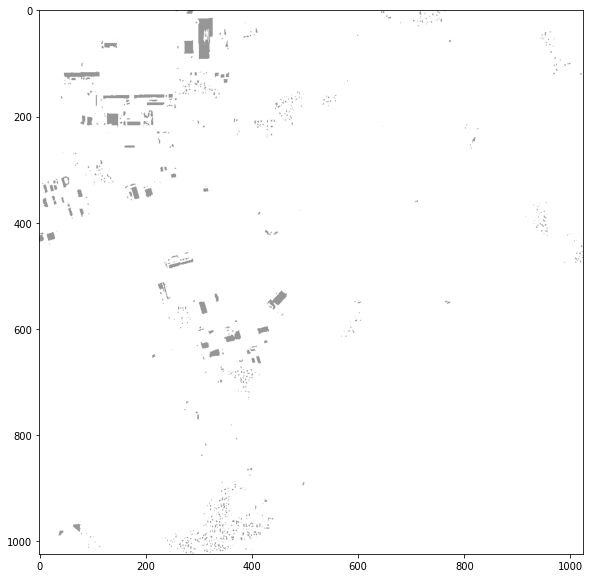

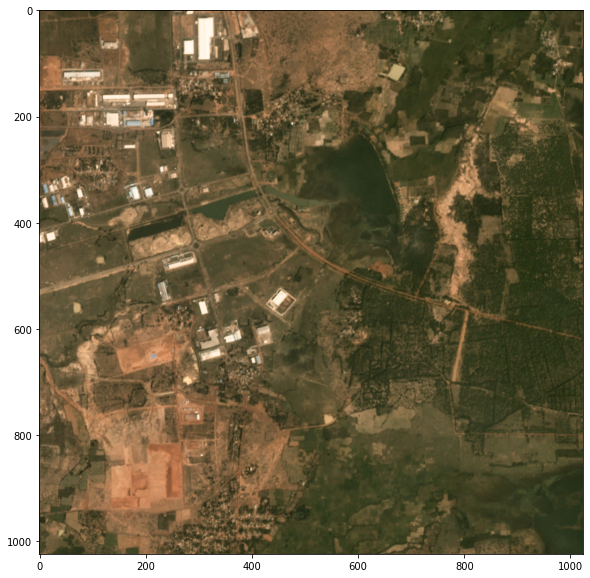

In [ ]:
from skimage import io
image = io.imread('/content/map.tif')
f, axarr = plt.subplots(figsize=(10, 10))
plt.imshow(image, cmap='gray')
image = io.imread(test_id)
f, axarr = plt.subplots(figsize=(10, 10))
plt.imshow(image[:,:,:3])